In [1]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import matplotlib as mpl
from comp_pdet import pdet
from pdet_gwbench import *
from tqdm.auto import tqdm
from joblib import Parallel, delayed, cpu_count
import logging

/data/fdesanti/fleto/master_thesis/box/lib/python3.11/site-packages/gwbench/basic_relations.py:20: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import GreenwichMeanSiderealTime


In [2]:
pdet(20, 20, 9, n_samples=1e4)

0.0008

Combinations of masses and redshifts for which the detection probability is virtually 1 (0.999#) or 0 (0.000#) for a CE (US A location) + ET (Sardinia) network and SNR threshold $8 \sqrt{2}$:

* $p_\text{det} \simeq 1$
    * Anything with $z \leq 0.1$ (and $m_\text{min} \geq 1$)
    * Anything with $z \leq 1$ and $m_\text{min} \geq 30$
    * Anything with $z \leq 2$ and $m_\text{min} \geq 85$
* $p_\text{det} \simeq 0$
    * Anything with $z \geq 6$ and $m_\text{max} \leq 10$
    * Anything with $z \geq 8$ and $m_\text{max} \leq 15$

In [3]:
z_max_m_min = ((0.1, 1), (1, 30), (2, 85))
z_min_m_max = ((6, 10), (8, 15))

In [4]:
m1grid = np.concatenate((np.linspace(1, 5, 15, endpoint=False),
                         np.linspace(5, 15, 30, endpoint=False),
                         np.linspace(15, 30, 15, endpoint=False),
                         np.linspace(30, 40, 30, endpoint=False),
                         np.linspace(40, 50, 10)))
m2grid = np.copy(m1grid)
zgrid = np.concatenate((np.geomspace(1e-4, 1e-1, 200, endpoint=False),
                        np.geomspace(1e-1, 1, 50, endpoint=False),
                        np.geomspace(1, 10, 50)))

grids = (m1grid, m2grid, zgrid)
meshcoord, meshgrid, pdet_for_interpolant = initialize_pdet_grids(grids, z_max_m_min, z_min_m_max)

pdet_for_interpolant number of points: 3000000; meshcoord shape: (450569, 3)


In [5]:
m1grid = np.linspace(50, 100, 51)
m2grid = np.copy(m1grid)
zgrid = np.concatenate((np.geomspace(1e-4, 1e-1, 200, endpoint=False),
                        np.geomspace(1e-1, 1, 50, endpoint=False),
                        np.geomspace(1, 10, 50)))

grids = (m1grid, m2grid, zgrid)
meshcoord, meshgrid, pdet_for_interpolant = initialize_pdet_grids(grids, z_max_m_min, z_min_m_max)

pdet_for_interpolant number of points: 780300; meshcoord shape: (63070, 3)


In [6]:
grids = merge_pdet_grids((*grids, pdet_for_interpolant), "data/pdet_nsamples_5e2_(attempt_4).npz")
meshcoord, meshgrid, pdet_for_interpolant = initialize_pdet_grids((grids["m1grid"], grids["m2grid"], grids["zgrid"]), z_max_m_min, z_min_m_max, pdet_for_interpolant=grids["pdet_for_interpolant"], shuffle=False)

pdet_for_interpolant number of points: 6750000; meshcoord shape: (0, 3)


In [7]:
file = np.load("data/pdet_nsamples_5e2_(attempt_4).npz")
m1grid, m2grid, zgrid, pdet_for_interpolant = [file[key] for key in file.files]
grids = (m1grid, m2grid, zgrid)

In [8]:
pdet_interpolant = RegularGridInterpolator(grids, pdet_for_interpolant, bounds_error=False, fill_value=None,
                                          method='linear')

In [9]:
pdet_interpolant(np.array([[10, 10, 1],
                           [24, 37, 5]]))

array([0.992     , 0.50880084])

In [10]:
seed = None
rng = np.random.RandomState(seed)
m1test = 10 ** rng.uniform(0, 2, 1000)
m2test = np.copy(m1test)
ztest = np.concatenate((10 ** rng.uniform(-2, 0, 200), rng.uniform(1, 10, 800)))

In [11]:
file = np.load("data/pdet_test_nsamples_1e3_npoints_1e3_(m_1_100_z_1e-2_10).npz")
m1test, m2test, ztest, pdet_test = [file[key] for key in file.files]

interpolated_pdet = pdet_interpolant(np.vstack((m1test, m2test, ztest)).T)

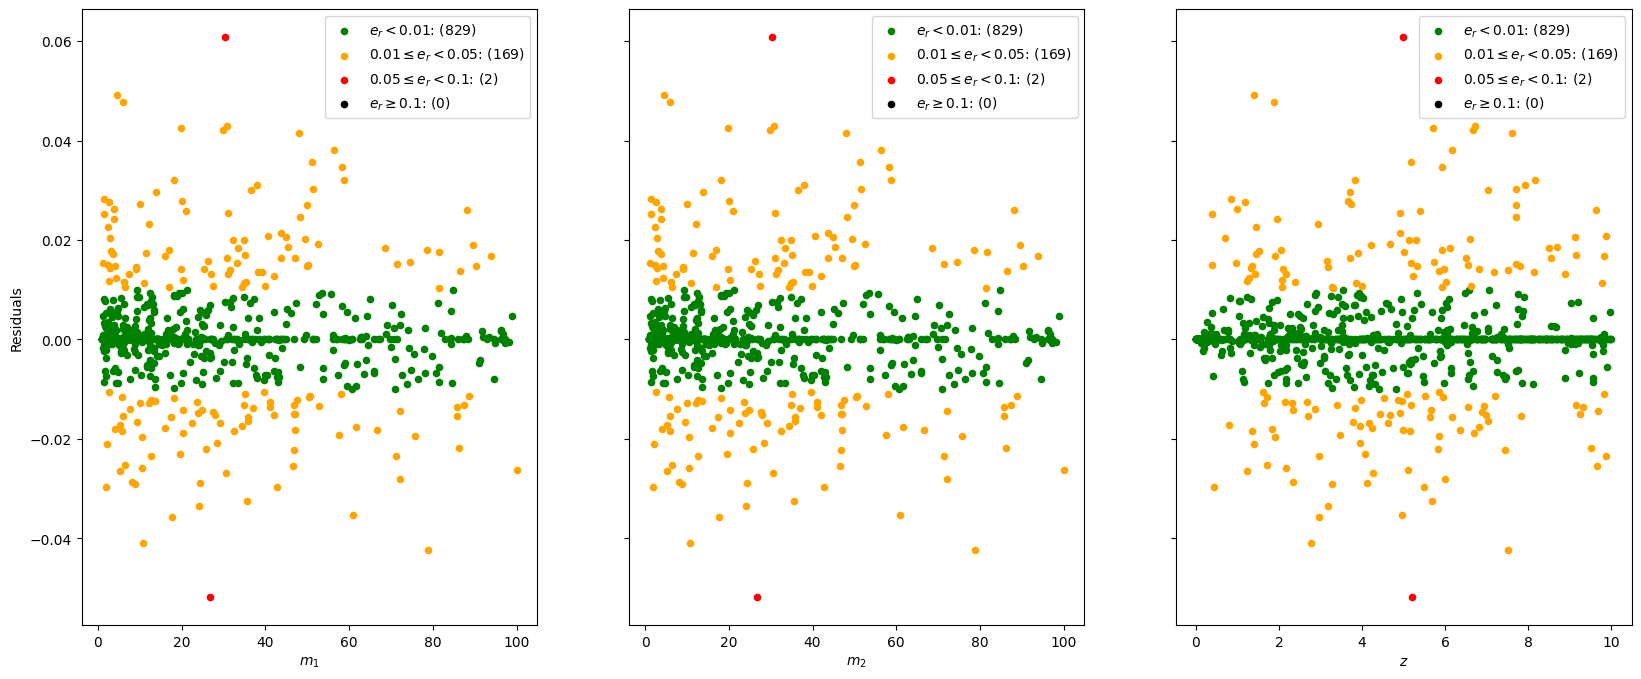

In [12]:
residuals = interpolated_pdet - pdet_test

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8), sharey=True)

levels_masks = (np.abs(residuals) < 0.01,
                (np.abs(residuals) >= 0.01) & (np.abs(residuals) < 0.05),
                (np.abs(residuals) >= 0.05) & (np.abs(residuals) < 0.1),
                np.abs(residuals) >= 0.1)
levels_colors = ('green', 'orange', 'red', 'black')
levels_labels = (r'$e_r < 0.01$: ({0})'.format(np.sum(levels_masks[0])),
                 r'$0.01 \leq e_r < 0.05$: ({0})'.format(np.sum(levels_masks[1])),
                 r'$0.05 \leq e_r < 0.1$: ({0})'.format(np.sum(levels_masks[2])),
                 r'$e_r \geq 0.1$: ({0})'.format(np.sum(levels_masks[3])))

for ax, grid, xlb in zip(axes, (m1test, m2test, ztest), (r'$m_1$', r'$m_2$', r'$z$')):
    for lv_mask, c, lvlb in zip(levels_masks, levels_colors, levels_labels):
        ax.scatter(grid[lv_mask], residuals[lv_mask], color=c, s=20, label=lvlb)
    ax.set_xlabel(xlb)
    ax.legend()
    
axes[0].set_ylabel('Residuals')

plt.show()

/tmp/ipykernel_438996/3913403867.py:1: RuntimeWarning: divide by zero encountered in divide
  rel_err = residuals / pdet_test
/tmp/ipykernel_438996/3913403867.py:1: RuntimeWarning: invalid value encountered in divide
  rel_err = residuals / pdet_test


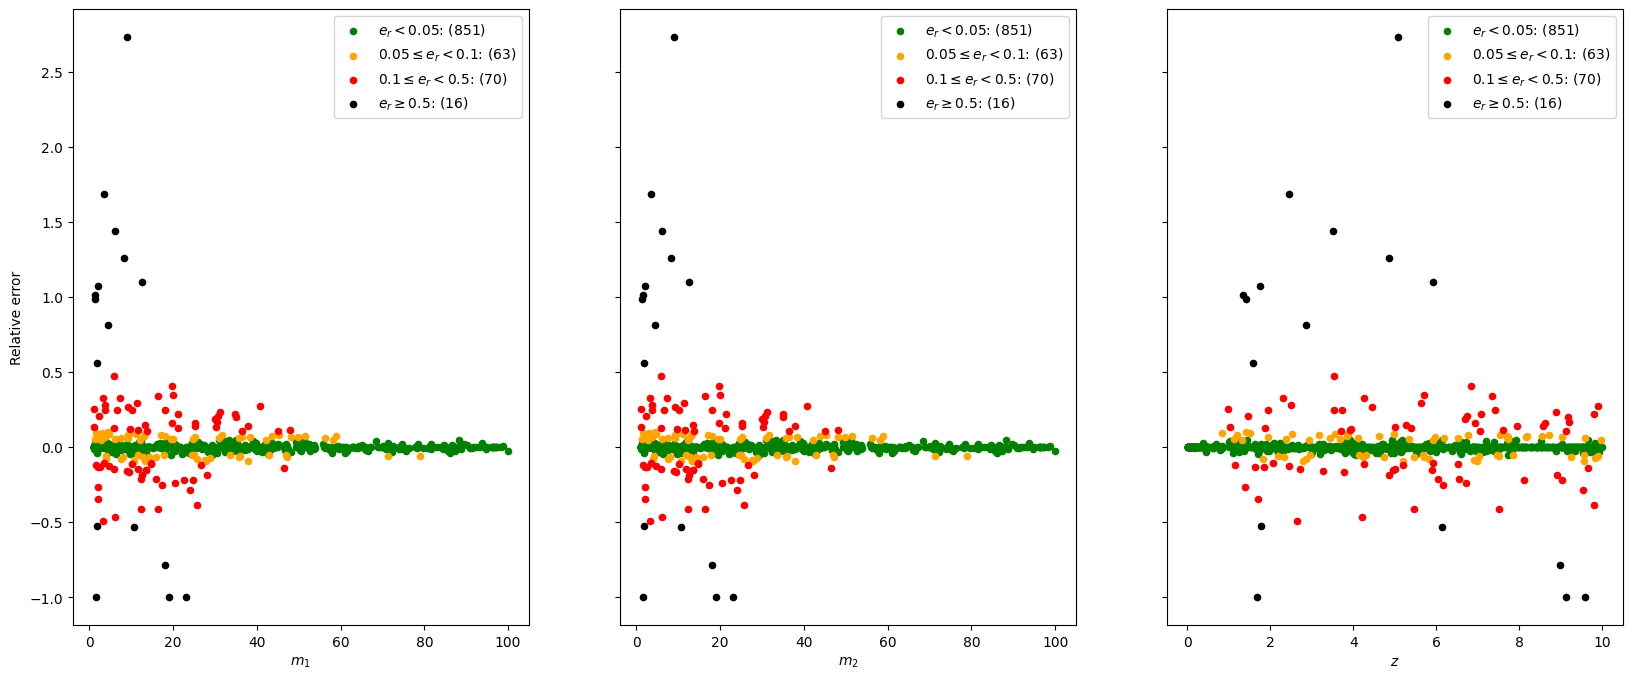

In [13]:
rel_err = residuals / pdet_test

nan_mask, inf_mask = np.isnan(rel_err), np.isinf(rel_err)

rel_err[nan_mask] = 0
rel_err[inf_mask] = interpolated_pdet[inf_mask]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8), sharey=True)

levels_masks = (np.abs(rel_err) < 0.05,
                (np.abs(rel_err) >= 0.05) & (np.abs(rel_err) < 0.1),
                (np.abs(rel_err) >= 0.1) & (np.abs(rel_err) < 0.5),
                np.abs(rel_err) >= 0.5)
levels_colors = ('green', 'orange', 'red', 'black')
levels_labels = (r'$e_r < 0.05$: ({0})'.format(np.sum(levels_masks[0])),
                 r'$0.05 \leq e_r < 0.1$: ({0})'.format(np.sum(levels_masks[1])),
                 r'$0.1 \leq e_r < 0.5$: ({0})'.format(np.sum(levels_masks[2])),
                 r'$e_r \geq 0.5$: ({0})'.format(np.sum(levels_masks[3])))

for ax, grid, xlb in zip(axes, (m1test, m2test, ztest), (r'$m_1$', r'$m_2$', r'$z$')):
    for lv_mask, c, lvlb in zip(levels_masks, levels_colors, levels_labels):
        ax.scatter(grid[lv_mask], rel_err[lv_mask], color=c, s=20, label=lvlb)
    ax.set_xlabel(xlb)
    ax.legend()
    
axes[0].set_ylabel('Relative error')

plt.show()